In [1]:
include("MiniCollectiveSpins.jl")
using PyPlot
using Statistics
using JLD2
import PhysicalConstants.CODATA2018: c_0
using Unitful
using ProgressMeter
using ProgressBars
using NonlinearSolve
using SteadyStateDiffEq
using Libdl
using Symbolics
using OrdinaryDiffEq

In [2]:
""" Prepare the initial vector u0 """
function u0_CFunction(phi_array, theta_array, op_list)
    u0 = ones(ComplexF64, length(op_list))
    for i in 1:length(op_list)
        if length(op_list[i]) == 1
            j = Int(op_list[i][1] % 10^floor(log10(abs(op_list[i][1]))-1)) # Atom nbr
            if parse(Int, string(op_list[i][1])[1:2]) == 22
                u0[i] = cos(theta_array[j]/2)^2
            elseif parse(Int, string(op_list[i][1])[1:2]) == 21
                u0[i] = cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
            else
                println(op_list[i][1])
            end
        end

        if length(op_list[i]) == 2
            for op in op_list[i]
                j = Int(op % 10^floor(log10(abs(op))-1)) # Atom nbr
                if parse(Int, string(op)[1:2]) == 22
                    u0[i] *= cos(theta_array[j]/2)^2
                elseif parse(Int, string(op)[1:2]) == 21
                    u0[i] *= cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
                elseif parse(Int, string(op)[1:2]) == 12
                    u0[i] *= cos(theta_array[j]/2)*exp(-1im*phi_array[j])*sin(theta_array[j]/2)
                else
                    println(op)
                end
            end
        end
    end
    return u0
end

""" Function loading the block subfunction when a lot of equations are involved """
function load_f(fname::String, libpath::String)
	lib = Libdl.dlopen(libpath)
	fptr = Libdl.dlsym(lib, fname)
	return (du, u, params) -> ccall(fptr, Cvoid, (Ptr{ComplexF64}, Ptr{ComplexF64}, Ptr{ComplexF64}), du, u, params)
end

""" Create a random distribution, save it, computes the corresponding parameters an return the stationnary state. 
If compute_t_evolution, compute the whole evolution, else only the stationnary state. """
function solve_random_distrib(chunk, op_list, compute_t_evolution, fcounter, N, d0_lb)
    popup_SS, popup_t = [], []
    nbr_error_ss = 0
    for i in chunk
        # Compute distribution
        L = (N/n)^(1/3) # Change the volume to keep the density cste
        r0 = [[rand(Float64)*L, rand(Float64)*L, rand(Float64)*L] for i in 1:N]

        # Choose a distribution where the minimum distance between the atoms is bigger than d0_min
        while min_r0(r0) < d0_lb
            r0 = [[rand(Float64)*L, rand(Float64)*L, rand(Float64)*L] for i in 1:N]
        end

        # Save the atoms position for comparison with QuantumOptics
        @save "r0/r0_N_$(N)_r_$i.jdl2" r0 L

        # Compute the parameters
        system = SpinCollection(r0, e, gammas=1.)
        Ω_CS = OmegaMatrix(system)
        Γ_CS = GammaMatrix(system)
        Γij_ = [Γ_CS[i, j] for i = 1:N for j=1:N]
        Ωij_ = [Ω_CS[i, j] for i = 1:N for j=1:N if i≠j]
        exp_RO_ = [0 for i = N:-1:1] # [exp(1im*r0[i]'kl) for i = N:-1:1] # We go in the decreasing direction to avoid exp_RO(10) being replace by exp_RO(1)0
        conj_exp_RO_ = [0 for i = N:-1:1] #[exp(-1im*r0[i]'kl) for i = N:-1:1]
        p0 = ComplexF64.([Γij_; Ωij_; exp_RO_; conj_exp_RO_; Ω_RO/2])

        # Load the functions
        fsolve(du, u, p, t) = functions[fcounter](du, u, p0)

        ## Compute stationnary state ##
        # Prepare the guess for the steady state
        phi_array_f, theta_array_f = zeros(N), ones(N)*3π/4
        uf = u0_CFunction(phi_array_f, theta_array_f, op_list)

        # Compute stationnary state
        prob_ss = SteadyStateProblem(fsolve, uf)
        try # Sometimes bad final guess -> it can't find the stationnary state
            sol_ss = solve(prob_ss, DynamicSS())
            
            stationnary_state = sum(real(sol_ss[1:N]))
            push!(popup_SS, stationnary_state)

            if compute_t_evolution
                # ## Compute time evolution ##
                # Prepare the initial state
                phi_array_0, theta_array_0 = zeros(N), ones(N)*π # We start from all the atoms in the GS
                u0 = u0_CFunction(phi_array_0, theta_array_0, op_list)

                # Computation
                prob = OrdinaryDiffEq.ODEProblem(fsolve, u0, (T[1], T[end]))
                sol = OrdinaryDiffEq.solve(prob, OrdinaryDiffEq.DP5(), saveat=T;
                            reltol=1.0e-6,
                            abstol=1.0e-8).u
                push!(popup_t, [sum(real(sol[i][1:N])) for i=1:length(T)])
            end
        catch e
            if e isa DifferentialEquations.MaxItersException
                @warn "maxiters exceeded at $i"
            else
                rethrow(e)
            end
            print("Error! N = $N, r = $i")
            nbr_error_ss += 1
        end
    end
    return popup_SS, popup_t, nbr_error_ss
end

""" Reconstruct the position of atoms """
function reconstruct_img_distrib(N, i)
    @load "r0/r0_N_$(N)_r_$i.jdl2" r0 L
    plt.close("all")
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    ax.scatter([r[1] for r in r0], [r[2] for r in r0], [r[3] for r in r0])
    ax.set_xlabel(L"x/$\lambda$")
    ax.set_ylabel(L"y/$\lambda$")
    ax.set_zlabel(L"z/$\lambda$")
    ax.set_xlim(0, L), ax.set_ylim(0, L), ax.set_zlim(0, L)
    plt.savefig("Images_distribution/IImages_distribution_N_$(N)_r_$i")
end


""" Return the minimum distance of a distribution of atoms r0 """
function min_r0(r0)
    N = length(r0)
    d0 = zeros(N, N) # Repetiton, atom i, distance from atom j
    for j in 1:N
        for k = 1:N
            d0[j, k] = norm(r0[j]-r0[k])
        end
    end
    return minimum(d0[d0 .> 0])
end

min_r0

### Define the system

In [3]:
# Nbr of particles
N_list = [2:2:2;];
r = 10 # Nbr of repetitions
list_r = 1:r

# Normalisation parameters
λ = 421e-9
γ = 32.7e6 # In Hz

# Physical values
ω0 = (2π*ustrip(c_0)/λ)
ωl = ω0
kl = [ustrip(c_0)/ωl, 0, 0] # Laser along x
Ω_RO = 1#1e7 # Taken from Barbut arXiv:2412.02541v1

# Fixed density
n = 2e3 # atoms per unit of volume (already normalized)
d0_lb = 0.1 # Minimum distance between the atoms (lower boundary)

# Normalization
ω0 = ω0 / γ
ωl = ωl / γ
kl = kl * λ
Ω_RO = Ω_RO / γ

# Quantization axis along z
e = [0, 0, 1.]

# Integration parameter
tstep = 0.1
T = [0:tstep:100;]; # Normalised time

In [4]:
# Prepare the wrapper
const N_FUNCS = length(N_list)  # Total function nbr
const functions = Vector{Function}(undef, N_FUNCS)

for (i, N) in enumerate(N_list)
    libpath ="libs/liballfuncs_$N.dll"
    functions[i] = load_f("diffeqf", libpath)
end

# Compute stationary state for each atom number

In [5]:
# Create the directories
if !isdir("r0")
    mkdir("r0")
end
if !isdir("Images_distribution")
    mkdir("Images_distribution")
end
if !isdir("solutions")
    mkdir("solutions")
end
nothing 

In [6]:
chunks = Iterators.partition(list_r, cld(length(list_r), Threads.nthreads()))
popup_SS_N, popup_t_N = [], []
error_N = []

for (i, N) in ProgressBar(enumerate(N_list))
    @load "op_list/op_list_$N.jdl2" op_list
    tasks = map(chunks) do chunk # Split the different distributions into chuncks solved on each core
        Threads.@spawn solve_random_distrib(chunk, op_list, false, i, N, d0_lb)
    end
    

    # Gather the data from the different threads
    sol_tasks = fetch.(tasks)
    push!(popup_SS_N, vcat([s[1] for s in sol_tasks]...))
    push!(popup_t_N, vcat([s[2] for s in sol_tasks]...))
    
    push!(error_N, sum([s[3] for s in sol_tasks]))
end

0.0%┣                                                ┫ 0/1 [00:01<00:-1, -1s/it]
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\Joschka\.julia\packages\SciMLBase\TZ9Rx\src\integrator_interface.jl:626
100.0%┣██████████████████████████████████████████┫ 1/1 [00:48<Inf:Inf, InfGs/it]
100.0%┣██████████████████████████████████████████┫ 1/1 [00:48<Inf:Inf, InfGs/it]


0.0%┣                                                ┫ 0/1 [00:00<00:00, -0s/it]
100.0%┣██████████████████████████████████████████┫ 1/1 [00:02<Inf:Inf, InfGs/it]
100.0%┣██████████████████████████████████████████┫ 1/1 [00:02<Inf:Inf, InfGs/it]


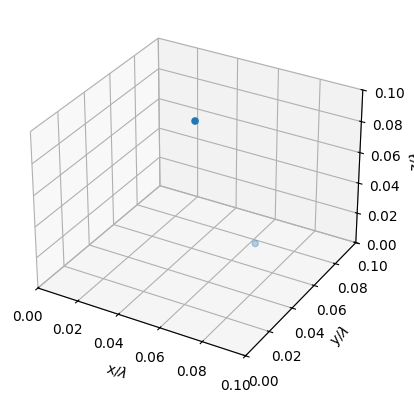

In [7]:
for N in ProgressBar(N_list)
    for i in list_r
        reconstruct_img_distrib(N, i)
    end
end

In [8]:
error_N

1-element Vector{Any}:
 0

In [9]:
@save "solutions/sol_N_$(N_list)_r_$(r)_n_$n" popup_SS_N popup_t_N

In [10]:
@load "solutions/sol_N_$(N_list)_r_$(r)_n_$n" popup_SS_N popup_t_N

2-element Vector{Symbol}:
 :popup_SS_N
 :popup_t_N

# Plots

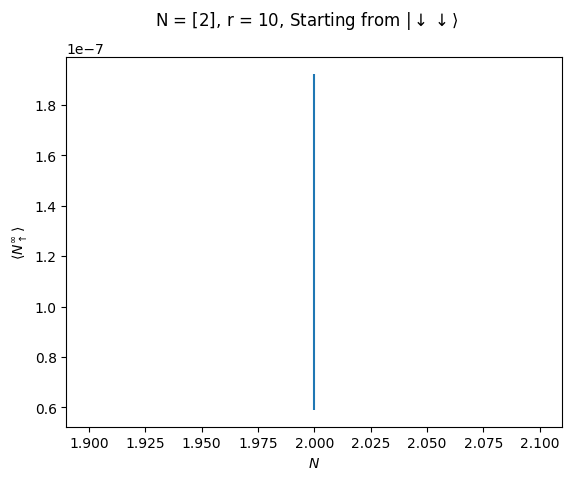

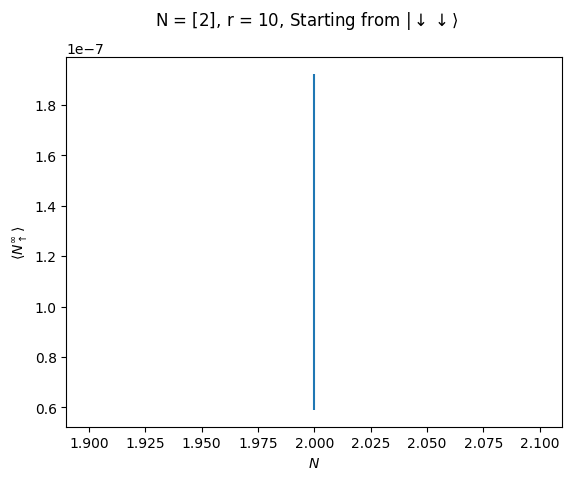

In [11]:
close("all")
fig = figure()
errorbar(N_list, [mean(popup_SS) for popup_SS in popup_SS_N], yerr=[std(popup_SS) for popup_SS in popup_SS_N])
xlabel(L"N")
ylabel(L"$\langle  N_{\uparrow}^\infty \rangle$")
suptitle("N = $N_list, r = $r, Starting from "*L"$|\downarrow \downarrow \rangle $")
pygui(false); gcf()
# pygui(true); show()

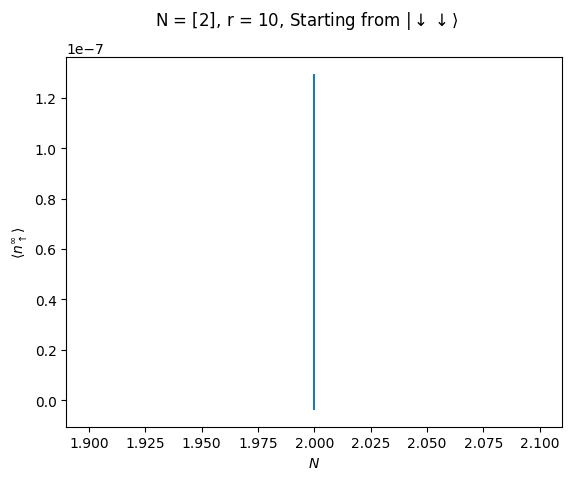

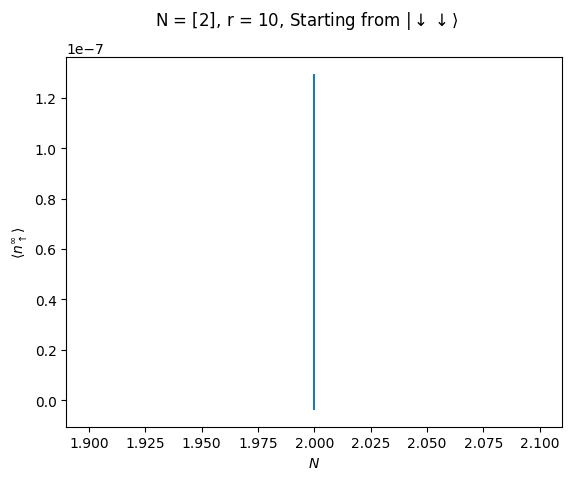

In [12]:
# Same plot bt normalised by the nbr of atoms
close("all")
fig = figure()
errorbar(N_list, [mean(popup_SS_N[i])/N_list[i] for i in 1:length(popup_SS_N)], yerr=[std(popup_SS) for popup_SS in popup_SS_N])
xlabel(L"N")
ylabel(L"$\langle  n_{\uparrow}^\infty \rangle$")
suptitle("N = $N_list, r = $r, Starting from "*L"$|\downarrow \downarrow \rangle $")
pygui(false); gcf()
# pygui(true); show()

In [13]:
# Computation with the time evolution final point
close("all")
fig = figure()
errorbar(N_list, [mean(p, dims=1)[1][end] for p in popup_t_N], yerr=[std(p)[end] for p in popup_t_N])
xlabel(L"N")
ylabel(L"$\langle  n_{\uparrow}^\infty \rangle$")
suptitle("N = $N_list, r = $r, Starting from "*L"$|\downarrow \downarrow \rangle $")
pygui(false); gcf()
# pygui(true); show()

LoadError: MethodError: no method matching zero(::Type{Any})
This error has been manually thrown, explicitly, so the method may exist but be intentionally marked as unimplemented.

[0mClosest candidates are:
[0m  zero(::Type{Union{Missing, T}}) where T
[0m[90m   @[39m [90mBase[39m [90m[4mmissing.jl:105[24m[39m
[0m  zero([91m::Type{Union{}}[39m, Any...)
[0m[90m   @[39m [90mBase[39m [90m[4mnumber.jl:315[24m[39m
[0m  zero([91m::Type{LibGit2.GitHash}[39m)
[0m[90m   @[39m [32mLibGit2[39m [90mC:\Users\Joschka\.julia\juliaup\julia-1.12.1+0.x64.w64.mingw32\share\julia\stdlib\v1.12\LibGit2\src\[39m[90m[4moid.jl:221[24m[39m
[0m  ...


In [ ]:
# Compare both
close("all")
fig = figure()
errorbar(N_list, [mean(popup_SS) for popup_SS in popup_SS_N], yerr=[std(popup_SS) for popup_SS in popup_SS_N], label="SS")
errorbar(N_list, [mean(p, dims=1)[1][end] for p in popup_t_N], yerr=[std(p)[end] for p in popup_t_N], label="Time evolution", linestyle="--")
legend()
xlabel(L"N")
ylabel(L"$\langle  n_{\uparrow}^\infty \rangle$")
suptitle("N = $N_list, r = $r, Starting from "*L"$|\downarrow \downarrow \rangle $")
pygui(false); gcf()
# pygui(true); show()

### Plot evolution

In [ ]:
close("all")
fig = figure()
for (i, N) in enumerate(N_list)
    line_mean, = plot(T, mean(popup_t_N[i]))
    hlines(mean(popup_SS_N[i]), T[1], T[end], linestyle="--", color = line_mean.get_color())

    for j in 1:r
        line, = plot(T, popup_t_N[i][j], linewidth=0.3)
        hlines(mean(popup_SS_N[i][j]), T[1], T[end], linestyle="--", color = line.get_color(), linewidth=0.3)

    end

end
# errorbar(N_list, [mean(popup_SS) for popup_SS in popup_SS_N], yerr=[std(popup_SS) for popup_SS in popup_SS_N])
xlabel(L"\gamma t")
ylabel(L"$\langle  n_{\uparrow} \rangle$")
suptitle("N = $N_list, r = $r, Starting from "*L"$|\downarrow \downarrow \rangle $")
# pygui(false); gcf()
pygui(true); show()

In [ ]:
close("all")
fig = figure()
for (i, N) in enumerate(N_list)
    line_mean, = plot(T, mean(popup_t_N[i])/N, label="N=$N")
    hlines(mean(popup_SS_N[i])/N, T[1], T[end], linestyle="--", color = line_mean.get_color())
end
# errorbar(N_list, [mean(popup_SS) for popup_SS in popup_SS_N], yerr=[std(popup_SS) for popup_SS in popup_SS_N])
xlabel(L"N")
ylabel(L"$\langle  n_{\uparrow}^\infty \rangle$")
suptitle("N = $N_list, r = $r, Starting from "*L"$|\downarrow \downarrow \rangle $")
legend()
pygui(false); gcf()
# pygui(true); show()

### Plot difference between time evolution final state and DynamicSS (also time evolution but different parameters/solver)

In [ ]:
close("all")
fig = figure()

line_mean, = plot(N_list, [mean(p, dims=1)[1][end] for p in popup_t_N]-[mean(popup_SS) for popup_SS in popup_SS_N], label="Mean")

for (i, N) in enumerate(N_list)
    for j = 1:r
        scatter(N, popup_t_N[i][j][end]-popup_SS_N[i][j])
    end
end

xlabel(L"N")
ylabel(L"$\langle  n_{\uparrow}^\infty \rangle^{time\ evolution} - \langle  n_{\uparrow}^\infty \rangle^{dynamicSS}$")
legend()
suptitle("N = $N_list, r = $r, Starting from "*L"$|\downarrow \downarrow \rangle $")
pygui(false); gcf()
# pygui(true); show()

### Stats on distance between atoms

In [ ]:
close("all")
figure()
for (n, N) in enumerate(N_list[1:2])
    d0_min = []
    for i = 1:r
        r0 = 0
        @load "r0/r0_N_$(N)_r_$i.jdl2" r0 L
        push!(d0_min, min_r0(r0))
    end
    plot([1:r;], d0_min, label="N = $N")
end
hlines(xmin=1, xmax=r, d0_lb)
xlabel(L"r")
ylabel(L"min(d_0/\lambda)")
legend()
pygui(false);

# Try to catch the error

In [ ]:
N = 4
i = 1

In [ ]:
L = (N/n)^(1/3) # Change the volume to keep the density cste
r0 = [[rand(Float64)*L, rand(Float64)*L, rand(Float64)*L] for i in 1:N]

# Choose a distribution where the minimum distance between the atoms is bigger than d0_min
while min_r0(r0) < d0_lb
    r0 = [[rand(Float64)*L, rand(Float64)*L, rand(Float64)*L] for i in 1:N]
end
min_r0(r0)

In [ ]:
# Compute the parameters
system = SpinCollection(r0, e, gammas=1.)
Ω_CS = OmegaMatrix(system)
Γ_CS = GammaMatrix(system)
Γij_ = [Γ_CS[i, j] for i = 1:N for j=1:N]
Ωij_ = [Ω_CS[i, j] for i = 1:N for j=1:N if i≠j]
exp_RO_ = [exp(1im*r0[i]'kl) for i = N:-1:1] # We go in the decreasing direction to avoid exp_RO(10) being replace by exp_RO(1)0
conj_exp_RO_ = [exp(-1im*r0[i]'kl) for i = N:-1:1]
p0 = ComplexF64.([Γij_; Ωij_; exp_RO_; conj_exp_RO_; Ω_RO/2])

In [ ]:

# Load the functions
fsolve(du, u, p, t) = functions[fcounter](du, u, p0)

## Compute stationnary state ##
# Prepare the guess for the steady state
phi_array_f, theta_array_f = zeros(N), ones(N)*3π/4
uf = u0_CFunction(phi_array_f, theta_array_f, op_list)

# Compute stationnary state
prob_ss = SteadyStateProblem(fsolve, uf)
try # Sometimes bad final guess -> it can't find the stationnary state
    sol_ss = solve(prob_ss, DynamicSS())
    
    stationnary_state = sum(real(sol_ss[1:N]))
    push!(popup_SS, stationnary_state)

    if compute_t_evolution
        # ## Compute time evolution ##
        # Prepare the initial state
        phi_array_0, theta_array_0 = zeros(N), ones(N)*π # We start from all the atoms in the GS
        u0 = u0_CFunction(phi_array_0, theta_array_0, op_list)

        # Computation
        prob = OrdinaryDiffEq.ODEProblem(fsolve, u0, (T[1], T[end]))
        sol = OrdinaryDiffEq.solve(prob, OrdinaryDiffEq.DP5(), saveat=T;
                    reltol=1.0e-6,
                    abstol=1.0e-8).u
        push!(popup_t, [sum(real(sol[i][1:N])) for i=1:length(T)])
    end
catch e
    if e isa DifferentialEquations.MaxItersException
        @warn "maxiters exceeded at $i"
    else
        rethrow(e)
    end
    print("Error! N = $N, r = $i")
    nbr_error_ss += 1